## **EXP3 Predicting Real Missing Cell-Types from Bulks using Non-Negative Least Squares Regression Residual**

*This file includes EXP3 analysis and results. Files used were created in preprocessing/EXP3_pseudos notebook, and deconvolution was performed with EXP3_adp_BayesPrism.R script.*

**Summary:**
Using single nucleus and single cell RNA-seq datasets with real missing cell types.

The residual is calculated in three different ways named: Residual (comparing BayesPrism calculated proportions to pseudobulks), Residual_diffbase (using different baseline being comapred to), and Residual_realref (using a "real" reference profile for cell lines).

**Hypothesis:**
Deleting cell types from BayesPrism reference will create a residual from which we can extract missing cell type information. 

**Deconv. Method:**
BayesPrism

**Factorization Methods:**
NMF

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess as prep
from functions import validation_processing as vp
from importlib import reload
reload(prep)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

In [2]:
#####################
### set the study ###
#####################
#these parameters are set in papermill 
res_name = "MCT_adp_EXP3"
pseudos_name = "MCT_adp_EXP3"
path = "/../data/"
aug_data_path = "/../data/EXP3/"
path_results = "/../results/EXP3/"
data_path = "/../data/EXP3/BayesPrism/"
bp_path = "/../data/EXP3/BP_results/"
bulkprop_type = "realistic"
noise_type = "nonoise"
num_missing_cells = [0,2]
nmf_cut = "minimum_value"
num_samples = 10000
random_seed = 88
bulk_type = f"{bulkprop_type}prop_{noise_type}"

In [3]:
actual_path = os.getcwd()
path = f"{actual_path}{path}"
aug_data_path = f"{actual_path}{aug_data_path}"
data_path = f"{actual_path}{data_path}"
bp_path = f"{actual_path}{bp_path}"
path_results = f"{actual_path}{path_results}"

Opening mixture file of pseudobulks and anndata for reference:

In [4]:
pseudo_path = os.path.join(data_path, f"{res_name}_{bulk_type}_mixture.csv")
pseudo_path = Path(pseudo_path)
# Open the CSV file of mixture used
pseudo_df = pd.read_csv(pseudo_path, sep=",")
#extracting gene_ids and setting as columns
pseudo_df.rename(columns = {'Unnamed: 0':'gene_ids'}, inplace = True)
gene_ids = pseudo_df["gene_ids"]
pseudo_df = pseudo_df.T
pseudo_df.columns = gene_ids
pseudo_df = pseudo_df.drop(labels = "gene_ids")
pseudo_df_copy = pseudo_df.copy()
pseudo_df

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
0,54.0,129.0,16.0,2119.0,122.0,37.0,696.0,15.0,156.0,6.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0
1,56.0,128.0,16.0,2985.0,139.0,56.0,679.0,15.0,249.0,6.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
2,56.0,115.0,13.0,2966.0,94.0,53.0,747.0,12.0,260.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,44.0,100.0,18.0,3364.0,114.0,66.0,806.0,16.0,222.0,9.0,...,0.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,3.0,0.0
4,59.0,127.0,13.0,2712.0,93.0,46.0,699.0,10.0,220.0,11.0,...,0.0,1.0,0.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,57.0,120.0,16.0,2365.0,85.0,54.0,720.0,12.0,259.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0
996,69.0,128.0,21.0,2261.0,66.0,54.0,748.0,19.0,216.0,5.0,...,0.0,0.0,0.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0
997,52.0,118.0,12.0,2606.0,107.0,53.0,753.0,19.0,181.0,5.0,...,1.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,4.0,1.0
998,42.0,112.0,9.0,2961.0,118.0,65.0,702.0,15.0,209.0,5.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [5]:
#and importing anndata object, with 2 missing
adata_path = os.path.join(data_path, f"{pseudos_name}_scadata_limitedcells_notlog.h5ad")
adata_path = Path(adata_path)
sc_adata = sc.read_h5ad(adata_path)
sc_adata_copy = sc_adata.copy()
sc_adata

AnnData object with n_obs × n_vars = 5619 × 26672
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'batch'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [6]:
#and importing anndata object with 0 missing
adata_path = os.path.join(aug_data_path, f"{pseudos_name}_snadata_limitedcells_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
sn_adata_copy = sn_adata.copy()
sn_adata

AnnData object with n_obs × n_vars = 11271 × 28242
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'batch'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [7]:
#making sure cell types are capitalized:
sn_adata.obs["cell_types"] = vp.capitalize_first_letters(sn_adata.obs["cell_types"])
sc_adata.obs["cell_types"] = vp.capitalize_first_letters(sc_adata.obs["cell_types"])
print(Counter(sc_adata.obs["cell_types"]))
# define the number of cells and the list of missing cell counts
num_cells = len(sc_adata.obs.cell_types.unique())
cell_order = sc_adata.obs.cell_types.unique()

Counter({'Preadipocyte': 1000, 'Macrophage': 1000, 'Dendritic cell': 983, 'T cell': 807, 'Monocyte': 636, 'Endothelial cell': 542, 'Immature nk t cell': 389, 'Endothelial cell of lymphatic vessel': 157, 'Mast cell': 53, 'Pericyte cell': 52})


## **Reading In and QCing the BayesPrism Results:**

BayesPrism Results:

In [8]:
#import all BayesPrism results (through using InstaPrism) and real proportions
bp_prop = dict()
real_prop_reb = dict()
real_prop = dict()
ref_bp = dict()
gene_ids = dict()
for num in num_missing_cells:
    bp_results_path = os.path.join(bp_path, f"{res_name}_{num}missing_{bulk_type}_InstaPrism_results.csv")
    bp_results_path = Path(bp_results_path)
    # Open the CSV file in read mode
    bp_prop[num] = pd.read_csv(bp_results_path, sep="\t")
    bp_prop[num] = bp_prop[num].T
    bp_prop[num].columns = vp.capitalize_first_letters(bp_prop[num].columns)
    #real proportions
    realprop_results_path = os.path.join(data_path, f"{res_name}_{num}missing_{bulk_type}_prop.csv")
    realprop_results_path = Path(realprop_results_path)
    # Open the CSV file in read mode
    real_prop[num] = pd.read_csv(realprop_results_path, sep=",")
    #index from CSV file
    if "Unnamed: 0" in real_prop[num].columns:
        real_prop[num] = real_prop[num].drop(columns="Unnamed: 0")
    #real rebalanced proportions, we will delete the cell types
    real_prop[num].columns = vp.capitalize_first_letters(real_prop[num].columns)
    realrebprop_results_path = os.path.join(data_path, f"{res_name}_{num}missing_{bulk_type}_proprebal.csv")
    realrebprop_results_path = Path(realrebprop_results_path)
    # Open the CSV file
    real_prop_reb[num] = pd.read_csv(realrebprop_results_path, sep=",")
    #index from CSV file
    if "Unnamed: 0" in real_prop_reb[num].columns:
        real_prop_reb[num] = real_prop_reb[num].drop(columns = ["Unnamed: 0"])
    real_prop_reb[num].columns = vp.capitalize_first_letters(real_prop_reb[num].columns)

In [9]:
#rebalancing proportions with the missing cell types, and deleting from [2]
real_prop_reb[2] = real_prop_reb[2].div(real_prop_reb[2].sum(axis=1), axis=0)
real_prop_reb[2]

,Macrophage,Preadipocyte,Endothelial cell,Endothelial cell of lymphatic vessel,Pericyte cell,T cell,Dendritic cell,Mast cell,Monocyte,Immature nk t cell
0,0.243892,0.492832,0.037436,0.042634,0.008143,0.030572,0.003782,0.066987,0.041527,0.032196
1,0.162947,0.471540,0.185926,0.034532,0.013246,0.008435,0.007388,0.099242,0.006185,0.010558
2,0.114435,0.509977,0.286340,0.009191,0.004737,0.041428,0.011379,0.007910,0.001741,0.012862
3,0.271060,0.423295,0.189083,0.009622,0.025585,0.010012,0.013851,0.030868,0.019559,0.007066
4,0.349037,0.458659,0.104464,0.007395,0.024062,0.033428,0.004099,0.011356,0.002015,0.005485
...,...,...,...,...,...,...,...,...,...,...
995,0.189719,0.482119,0.100658,0.136136,0.010396,0.061093,0.007186,0.002220,0.002917,0.007557
996,0.162119,0.552184,0.082451,0.030445,0.100367,0.049432,0.015111,0.002267,0.004562,0.001061
997,0.217707,0.428189,0.165778,0.019224,0.041912,0.101749,0.002472,0.004065,0.015058,0.003845
998,0.275079,0.458155,0.162132,0.018567,0.003357,0.044815,0.001617,0.014536,0.007464,0.014277


In [10]:
for num in num_missing_cells:
    #and the reference used in BP
    ref_results_path = os.path.join(bp_path, f"{res_name}_{num}missing_{bulk_type}_InstaPrism_usedref.csv")
    ref_results_path = Path(ref_results_path)
    # Open the CSV file in read mode
    ref_bp[num] = pd.read_csv(ref_results_path, sep="\t")
    ref_bp[num].columns = vp.capitalize_first_letters(ref_bp[num].columns)
    #gene ids used for each
    gene_ids[num] = ref_bp[num].index
    #match columns and index
    bp_prop[num].index =  real_prop_reb[num].index
bp_prop[2]    

,Monocyte,Preadipocyte,Endothelial cell of lymphatic vessel,T cell,Dendritic cell,Macrophage,Endothelial cell,Immature nk t cell,Pericyte cell,Mast cell
0,0.111745,0.547737,0.030041,4.446591e-323,4.940656e-323,6.422853e-323,0.069705,0.013923,0.209787,0.017062
1,0.088092,0.525120,0.027520,4.446591e-323,4.940656e-323,5.928788e-323,0.128901,0.006130,0.200211,0.024026
2,0.066610,0.537133,0.024099,4.446591e-323,4.940656e-323,5.928788e-323,0.157398,0.010305,0.198278,0.006176
3,0.127595,0.503505,0.014743,4.446591e-323,4.940656e-323,6.243486e-306,0.114010,0.005614,0.222118,0.012414
4,0.142376,0.524248,0.024942,4.446591e-323,4.940656e-323,3.484794e-175,0.095416,0.008771,0.193296,0.010951
...,...,...,...,...,...,...,...,...,...,...
995,0.093551,0.538747,0.053328,4.446591e-323,4.940656e-323,5.928788e-323,0.099526,0.010987,0.196778,0.007085
996,0.077481,0.583372,0.026358,4.446591e-323,4.940656e-323,5.928788e-323,0.077501,0.007207,0.221844,0.006237
997,0.097706,0.523585,0.025837,5.816373e-306,4.940656e-323,5.928788e-323,0.109473,0.016255,0.218877,0.008267
998,0.118883,0.524904,0.020232,4.446591e-323,4.940656e-323,5.382090e-294,0.100860,0.012787,0.212668,0.009667


Ordering cells:

In [11]:
for num in num_missing_cells:
    bp_prop[num] = prep.sort_columns_alphabetically(bp_prop[num])
    real_prop_reb[num] = prep.sort_columns_alphabetically(real_prop_reb[num])
    ref_bp[num] = prep.sort_columns_alphabetically(ref_bp[num])
    #again, no real proortions of 0 missing, so only ordering 2.
    real_prop[num] = prep.sort_columns_alphabetically(real_prop[num])    
real_prop_reb[num]

,Dendritic cell,Endothelial cell,Endothelial cell of lymphatic vessel,Immature nk t cell,Macrophage,Mast cell,Monocyte,Pericyte cell,Preadipocyte,T cell
0,0.003782,0.037436,0.042634,0.032196,0.243892,0.066987,0.041527,0.008143,0.492832,0.030572
1,0.007388,0.185926,0.034532,0.010558,0.162947,0.099242,0.006185,0.013246,0.471540,0.008435
2,0.011379,0.286340,0.009191,0.012862,0.114435,0.007910,0.001741,0.004737,0.509977,0.041428
3,0.013851,0.189083,0.009622,0.007066,0.271060,0.030868,0.019559,0.025585,0.423295,0.010012
4,0.004099,0.104464,0.007395,0.005485,0.349037,0.011356,0.002015,0.024062,0.458659,0.033428
...,...,...,...,...,...,...,...,...,...,...
995,0.007186,0.100658,0.136136,0.007557,0.189719,0.002220,0.002917,0.010396,0.482119,0.061093
996,0.015111,0.082451,0.030445,0.001061,0.162119,0.002267,0.004562,0.100367,0.552184,0.049432
997,0.002472,0.165778,0.019224,0.003845,0.217707,0.004065,0.015058,0.041912,0.428189,0.101749
998,0.001617,0.162132,0.018567,0.014277,0.275079,0.014536,0.007464,0.003357,0.458155,0.044815


QC imported files:

In [12]:
bp_prop[2] #bayes prism proportions with 2 missing

,Dendritic cell,Endothelial cell,Endothelial cell of lymphatic vessel,Immature nk t cell,Macrophage,Mast cell,Monocyte,Pericyte cell,Preadipocyte,T cell
0,4.940656e-323,0.069705,0.030041,0.013923,6.422853e-323,0.017062,0.111745,0.209787,0.547737,4.446591e-323
1,4.940656e-323,0.128901,0.027520,0.006130,5.928788e-323,0.024026,0.088092,0.200211,0.525120,4.446591e-323
2,4.940656e-323,0.157398,0.024099,0.010305,5.928788e-323,0.006176,0.066610,0.198278,0.537133,4.446591e-323
3,4.940656e-323,0.114010,0.014743,0.005614,6.243486e-306,0.012414,0.127595,0.222118,0.503505,4.446591e-323
4,4.940656e-323,0.095416,0.024942,0.008771,3.484794e-175,0.010951,0.142376,0.193296,0.524248,4.446591e-323
...,...,...,...,...,...,...,...,...,...,...
995,4.940656e-323,0.099526,0.053328,0.010987,5.928788e-323,0.007085,0.093551,0.196778,0.538747,4.446591e-323
996,4.940656e-323,0.077501,0.026358,0.007207,5.928788e-323,0.006237,0.077481,0.221844,0.583372,4.446591e-323
997,4.940656e-323,0.109473,0.025837,0.016255,5.928788e-323,0.008267,0.097706,0.218877,0.523585,5.816373e-306
998,4.940656e-323,0.100860,0.020232,0.012787,5.382090e-294,0.009667,0.118883,0.212668,0.524904,4.446591e-323


In [13]:
#The BayesPrism reference should sum to 1 for each cell type expression
ref_bp[2].sum(axis =0)

Dendritic cell                          1.0
Endothelial cell                        1.0
Endothelial cell of lymphatic vessel    1.0
Immature nk t cell                      1.0
Macrophage                              1.0
Mast cell                               1.0
Monocyte                                1.0
Pericyte cell                           1.0
Preadipocyte                            1.0
T cell                                  1.0
dtype: float64

In [14]:
#cutting to genes used in each one
pseudo_df = dict()
sn_adata = dict()
ref_df = dict()
for num in num_missing_cells:
    pseudo_df[num] = pseudo_df_copy[gene_ids[num]]
    sn_adata[num] = sn_adata_copy[:, gene_ids[num]]

Visualize BayesPrism proportions:

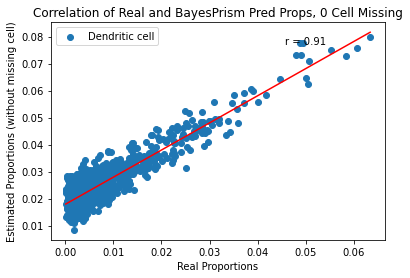

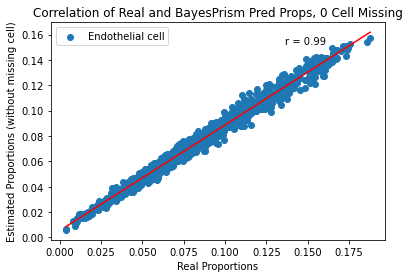

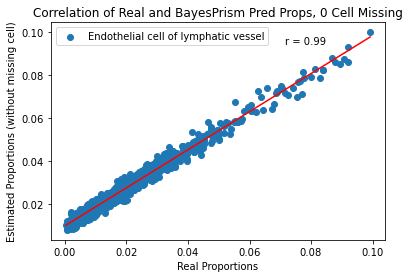

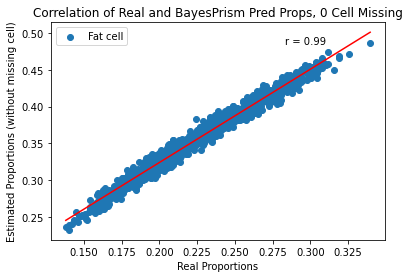

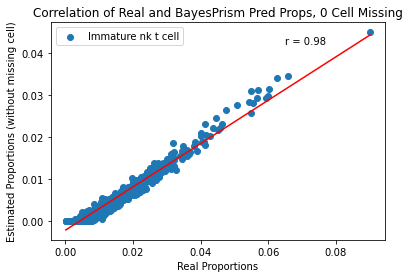

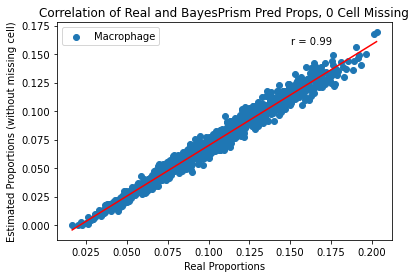

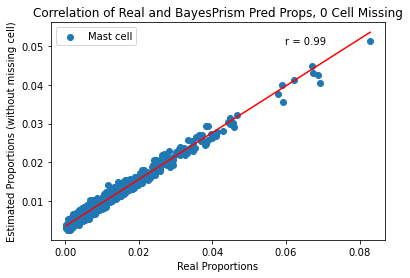

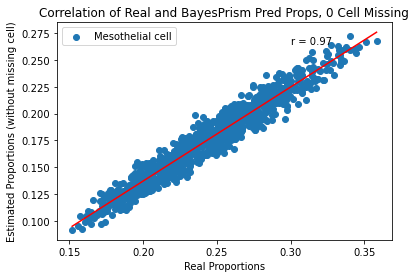

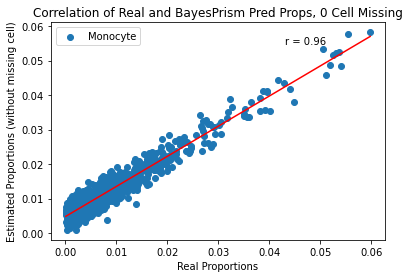

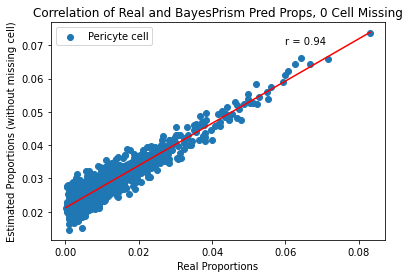

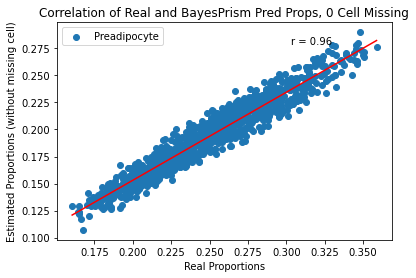

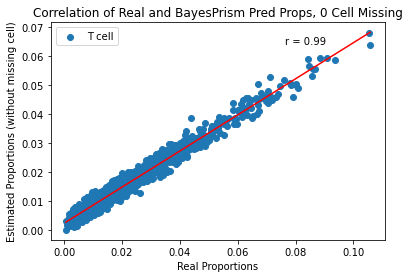

In [15]:
#Evaluation performance with no cell types missing, expect to be very close to 1.
num = 0
for col_cell in real_prop_reb[num].columns:
    x = real_prop_reb[num][col_cell].values.astype(float)
    y = bp_prop[num][col_cell].values.astype(float)
    correlation_coefficient = np.corrcoef(x, y)[0,1]
    plt.scatter(x, y, label= f"{col_cell}")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = "red")
    r, p = stats.pearsonr(x, y)
    plt.annotate('r = {:.2f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and BayesPrism Pred Props, {num} Cell Missing')
    plt.legend()
    plt.show()

Real Proportions shape: (1000, 12)
Estimated Proportions shape: (1000, 12)


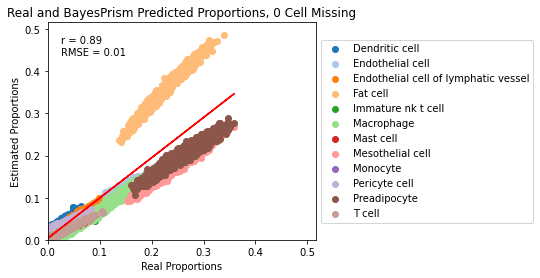

Real Proportions shape: (1000, 10)
Estimated Proportions shape: (1000, 10)


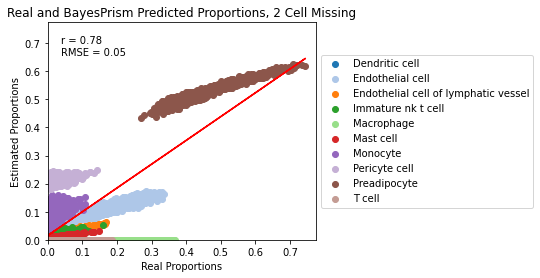

In [16]:
# Define colormap for coloring cell types
cmap = get_cmap('tab20') 

# Create a dictionary to store color mapping for each cell type
cell_type_colors = {}

for num in num_missing_cells:
    real_proportions = real_prop_reb[num].values.astype(float)  # real proportions of present cells
    estimated_proportions = bp_prop[num].values.astype(float)  # estimated proportions of present cells.
    cell_types = real_prop_reb[num].columns.tolist() 

    # Print the shapes of the matrices
    print("Real Proportions shape:", real_proportions.shape)
    print("Estimated Proportions shape:", estimated_proportions.shape)
    
    correlation_coefficient = np.corrcoef(real_proportions, estimated_proportions)[0, 1]

    # Scatter plot with colored points for each cell type
    fig, ax = plt.subplots()

    for i, cell_type in enumerate(cell_types):
        x = real_proportions[:, i]
        y = estimated_proportions[:, i]

        # Check if the cell type already has a color assigned
        if cell_type not in cell_type_colors:
            # Assign a unique color for each cell type
            color = cmap(len(cell_type_colors))
            cell_type_colors[cell_type] = color
        else:
            color = cell_type_colors[cell_type]

        ax.scatter(x, y, label=cell_type, color=color)

    # Fit a regression line
    m, b = np.polyfit(real_proportions.flatten(), estimated_proportions.flatten(), 1)
    plt.plot(real_proportions.flatten(), m * real_proportions.flatten() + b, color="red")

    r, p = stats.pearsonr(real_proportions.flatten(), estimated_proportions.flatten())

    # Calculate RMSE
    rmse = np.sqrt(((x - y) ** 2).mean())

    # And annotate
    plt.annotate(f'r = {r:.2f}\nRMSE = {rmse:.2f}', xy=(0.05, 0.85), xycoords='axes fraction')   
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions')
    plt.title(f'Real and BayesPrism Predicted Proportions, {num} Cell Missing')

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    max_val = max([real_proportions.max(), estimated_proportions.max()])
    if bulkprop_type == "realistic":
        ax.set_xlim(0,max_val+.03)
        ax.set_ylim(0,max_val+.03)
    else:    
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
    plt.show()

And saving results:

In [17]:
# Iterate through num_missing_cells
real_df = pd.DataFrame()
predicted_df = pd.DataFrame()

for num in num_missing_cells:
    real_proportions = real_prop_reb[num].values.astype(float)
    estimated_proportions = bp_prop[num].values.astype(float)
    cell_types = real_prop_reb[num].columns.tolist()

    # Create dataframes
    real_df_current = pd.DataFrame(data=real_proportions, columns=cell_types, index=[num]*len(real_proportions))
    predicted_df_current = pd.DataFrame(data=estimated_proportions, columns=cell_types, index=[num]*len(estimated_proportions))

    real_df = pd.concat([real_df, real_df_current])
    predicted_df = pd.concat([predicted_df, predicted_df_current])

# Save dataframes to .txt files
real_filename = f"{path_results}EXP3_bayesprism_adp_{bulkprop_type}_{noise_type}_real.txt"
predicted_filename = f"{path_results}EXP3_bayesprism_adp_{bulkprop_type}_{noise_type}_predicted.txt"

# Save dataframes to .txt files
with open(real_filename, 'w') as file:
    real_df.to_csv(file, sep='\t', index=True, header=True, mode='w')

with open(predicted_filename, 'w') as file:
    predicted_df.to_csv(file, sep='\t', index=True, header=True, mode='w')

## **Extracting Missing Cell Information:**

In [18]:
cells_to_miss = dict()
missing_cell_tot  = dict()

#cells that are missing
cells_to_miss = np.setdiff1d(real_prop_reb[0].columns, real_prop_reb[2].columns)
#extracting real proportions from missing cells
missing_cell_tot[2] = real_prop[0][cells_to_miss]
print(f"{num} missing: {missing_cell_tot[num].shape}")

# Get the corresponding missing_cell_proportions
missing_cell_prop = dict()
missing_cell_prop[0] = []
missing_cell_prop[2] = real_prop[0][missing_cell_tot[num].columns]  

2 missing: (1000, 2)


Recreated matrix:

In [19]:
#recreate matrix with calculated proportion BayesPrism and multiplying by the used reference
recreated_mat_all = dict()
for num in num_missing_cells:
        recreated_mat_all[num] = pd.DataFrame(ref_bp[num] @ bp_prop[num].T)
        recreated_mat_all[num] = recreated_mat_all[num].T
        recreated_mat_all[num].columns = gene_ids[num]
recreated_mat_all[0]   

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,TNK2-AS1,AC007991.4,AC010907.2,AC015712.4,OR2B11,AP003550.1,AC105924.1,AC239803.3,HIST1H3G,PAEP
0,0.000004,0.000010,1.119869e-06,0.000182,0.000008,0.000004,0.000052,8.257603e-07,0.000011,6.860842e-07,...,2.853585e-08,1.926793e-08,1.272530e-08,1.934786e-08,2.096599e-08,1.934786e-08,1.926793e-08,2.096599e-08,3.950184e-08,1.934786e-08
1,0.000004,0.000010,1.007145e-06,0.000249,0.000011,0.000004,0.000053,9.168154e-07,0.000015,7.825197e-07,...,2.835231e-08,1.917616e-08,1.045728e-08,2.084467e-08,1.512769e-08,2.084467e-08,1.917616e-08,1.512769e-08,3.348000e-08,2.084467e-08
2,0.000004,0.000010,1.023656e-06,0.000235,0.000007,0.000004,0.000056,9.733294e-07,0.000016,8.174265e-07,...,3.438388e-08,2.219194e-08,1.052443e-08,2.026660e-08,1.196790e-08,2.026660e-08,2.219194e-08,1.196790e-08,3.635178e-08,2.026660e-08
3,0.000004,0.000008,1.160020e-06,0.000238,0.000007,0.000004,0.000051,8.696954e-07,0.000014,6.574930e-07,...,4.081843e-08,2.540921e-08,1.000000e-08,2.328217e-08,1.769956e-08,2.328217e-08,2.540921e-08,1.769956e-08,4.851799e-08,2.328217e-08
4,0.000004,0.000011,9.458906e-07,0.000224,0.000006,0.000004,0.000051,9.465682e-07,0.000013,7.705178e-07,...,3.399189e-08,2.199594e-08,1.000000e-08,2.361350e-08,1.471967e-08,2.361350e-08,2.199594e-08,1.471967e-08,3.871156e-08,2.361350e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000004,0.000010,1.016843e-06,0.000195,0.000006,0.000004,0.000053,9.201849e-07,0.000015,7.938449e-07,...,2.601819e-08,1.800910e-08,1.000000e-08,1.914313e-08,1.379955e-08,1.914313e-08,1.800910e-08,1.379955e-08,2.981775e-08,1.914313e-08
996,0.000004,0.000010,1.126226e-06,0.000189,0.000006,0.000004,0.000054,9.150941e-07,0.000014,8.028278e-07,...,2.870021e-08,1.935011e-08,1.000000e-08,3.476443e-08,1.385686e-08,3.476443e-08,1.935011e-08,1.385686e-08,3.255708e-08,3.476443e-08
997,0.000004,0.000009,1.132680e-06,0.000204,0.000007,0.000004,0.000053,8.752540e-07,0.000013,6.380055e-07,...,2.770005e-08,1.885002e-08,1.000000e-08,2.428055e-08,1.472328e-08,2.428055e-08,1.885002e-08,1.472328e-08,3.242332e-08,2.428055e-08
998,0.000004,0.000009,1.130138e-06,0.000218,0.000007,0.000004,0.000052,8.624587e-07,0.000013,7.059397e-07,...,3.283054e-08,2.141527e-08,1.095547e-08,1.995752e-08,1.509932e-08,1.995752e-08,2.141527e-08,1.509932e-08,3.792987e-08,1.995752e-08


## **Calculate Residuals:**

Residual uses:

Pseudobulks - [Calculated_Proportions * Reference]

First normalizing the pseudobulks:

In [20]:
norm_pseudo_df = dict()
for num in num_missing_cells:
    #clipping before scaling to 95th pecentile
    pseudo_copy = pseudo_df[num].copy() #keeping genes
    pseudo = pseudo_copy.values #np array
    clip_upper = np.quantile(pseudo, 0.95)
    pseudo = np.clip(pseudo, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo)
    normalized_pseudo_df = scaler.transform(pseudo)
    normalized_pseudo_df = pd.DataFrame(normalized_pseudo_df, 
                                columns = pseudo_copy.columns, index= pseudo_copy.index)
    norm_pseudo_df[num] = normalized_pseudo_df     

In [21]:
#Residual as the the difference between the recreated matrix and pseudobulks.
residuals = dict()
for num in num_missing_cells:
    res = pseudo_df[num].values - recreated_mat_all[num].values
    residuals[num] = pd.DataFrame(res, columns = gene_ids[num])
residuals[0]    

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,TNK2-AS1,AC007991.4,AC010907.2,AC015712.4,OR2B11,AP003550.1,AC105924.1,AC239803.3,HIST1H3G,PAEP
0,53.999996,128.99999,15.999999,2118.999818,121.999992,36.999996,695.999948,14.999999,155.999989,5.999999,...,2.0,-0.0,-0.0,1.0,-0.0,-0.0,3.0,-0.0,-0.0,2.0
1,55.999996,127.99999,15.999999,2984.999751,138.999989,55.999996,678.999947,14.999999,248.999985,5.999999,...,-0.0,1.0,1.0,-0.0,1.0,-0.0,1.0,-0.0,1.0,1.0
2,55.999996,114.99999,12.999999,2965.999765,93.999993,52.999996,746.999944,11.999999,259.999984,7.999999,...,-0.0,-0.0,2.0,1.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0
3,43.999996,99.999992,17.999999,3363.999762,113.999993,65.999996,805.999949,15.999999,221.999986,8.999999,...,2.0,2.0,2.0,-0.0,1.0,-0.0,1.0,2.0,1.0,3.0
4,58.999996,126.999989,12.999999,2711.999776,92.999994,45.999996,698.999949,9.999999,219.999987,10.999999,...,1.0,1.0,1.0,2.0,-0.0,-0.0,3.0,1.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,56.999996,119.99999,15.999999,2364.999805,84.999994,53.999996,719.999947,11.999999,258.999985,5.999999,...,-0.0,1.0,1.0,2.0,-0.0,-0.0,1.0,-0.0,1.0,2.0
996,68.999996,127.99999,20.999999,2260.999811,65.999994,53.999996,747.999946,18.999999,215.999986,4.999999,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,3.0,-0.0,1.0,1.0
997,51.999996,117.999991,11.999999,2605.999796,106.999993,52.999996,752.999947,18.999999,180.999987,4.999999,...,4.0,-0.0,-0.0,-0.0,-0.0,1.0,2.0,1.0,1.0,4.0
998,41.999996,111.999991,8.999999,2960.999782,117.999993,64.999996,701.999948,14.999999,208.999987,4.999999,...,-0.0,1.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0


In [22]:
ref_bp_scaled = dict()
pseudo_scaled = dict()
for num in num_missing_cells:
    #clippign before scaling to 95th pecentile
    ref_raw_val = ref_bp[num].values ##reference of bayes prism
    clip_upper = np.quantile(ref_raw_val, 0.95)
    ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
    #and scaling to be between values 0 and 1 
    scaler = MinMaxScaler()
    scaler.fit(ref_raw_val)
    ref_scale = scaler.transform(ref_raw_val)
    ref_bp_scaled[num] = pd.DataFrame(ref_scale, index = gene_ids[num], 
                                columns = real_prop_reb[num].columns)

    #clippign before scaling to 95th pecentile
    pseudo_raw_val = pseudo_df[num][ref_bp[num].index].values ##pseudobulks
    clip_upper = np.quantile(pseudo_raw_val, 0.95)
    pseudo_raw_val = np.clip(pseudo_raw_val, 0, clip_upper)
    #and scaling to be between values 0 and 1 
    scaler = MinMaxScaler()
    scaler.fit(pseudo_raw_val)
    pseudo_scale = scaler.transform(pseudo_raw_val)
    pseudo_scaled[num] = pd.DataFrame(pseudo_scale, columns = gene_ids[num])

In [23]:
print(ref_bp[2].max().max())
print(ref_bp_scaled[2].max().max())

0.0248349196486515
0.9999999999999999


In [24]:
print(pseudo_df[2].max().max())
print(pseudo_scaled[2].max().max())

119060.0
1.0000000000000036


In [25]:
#Residual with the scaled pseudobulk and scaled bayes prism reference
residuals_scaled = dict()
for num in num_missing_cells:
    res = (pseudo_scaled[num].values)  - (bp_prop[num] @ ref_bp_scaled[num].T)
    residuals_scaled[num] = pd.DataFrame(res, columns = gene_ids[num])
residuals_scaled[0]    

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,TNK2-AS1,AC007991.4,AC010907.2,AC015712.4,OR2B11,AP003550.1,AC105924.1,AC239803.3,HIST1H3G,PAEP
0,0.491367,0.532749,0.421753,-0.281358,0.414715,0.074564,0.023427,0.352131,0.010500,0.259004,...,0.399886,-0.000057,-1.674247e-05,0.249943,-0.000067,-0.000057,0.428514,-0.000067,-0.000181,0.222165
1,0.523958,0.522192,0.422446,0.226206,0.528630,0.381198,-0.036702,0.351572,0.616181,0.258412,...,-0.000113,0.249944,1.999972e-01,-0.000067,0.333302,-0.000067,0.142801,-0.000032,0.249856,0.111044
2,0.524152,0.380134,0.315201,0.225536,0.207275,0.332902,0.158183,0.244082,0.685546,0.363461,...,-0.000150,-0.000075,3.999968e-01,0.249937,0.333321,-0.000063,-0.000075,-0.000012,-0.000162,0.111048
3,0.328359,0.224383,0.492935,0.250332,0.359384,0.540953,0.365791,0.387576,0.441989,0.417075,...,0.399811,0.499905,4.000000e-01,-0.000082,0.333286,-0.000082,0.142762,0.399953,0.249763,0.333252
4,0.572660,0.506825,0.315679,0.070586,0.205679,0.219089,0.040192,0.172818,0.435989,0.521644,...,0.199853,0.249926,2.000000e-01,0.499916,-0.000029,-0.000084,0.428498,0.199971,-0.000176,-0.000084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.540582,0.434265,0.422386,-0.158974,0.143411,0.349241,0.092510,0.244408,0.681997,0.258342,...,-0.000098,0.249951,2.000000e-01,0.499944,-0.000023,-0.000056,0.142808,-0.000023,0.249878,0.222166
996,0.740004,0.522605,0.600285,-0.204860,0.002033,0.347830,0.171800,0.494440,0.402226,0.205656,...,-0.000115,-0.000057,-5.463617e-104,-0.000152,-0.000024,-0.000152,0.428514,-0.000024,0.249861,0.110959
997,0.459004,0.414350,0.278817,0.053429,0.306787,0.332951,0.190222,0.494684,0.172457,0.206668,...,0.799891,-0.000054,-1.098154e-60,-0.000088,-0.000029,0.333246,0.285660,0.199971,0.249862,0.444357
998,0.293461,0.352466,0.171690,0.251888,0.389872,0.525318,0.043921,0.351906,0.357398,0.206251,...,-0.000140,0.249930,1.999941e-01,-0.000061,-0.000031,-0.000061,-0.000070,-0.000031,-0.000172,0.111050


Only show RMSE value if the proportions are random:

In [26]:
if bulkprop_type == "random":
    rmse_plot = True
else:
    rmse_plot = False    

## NMF

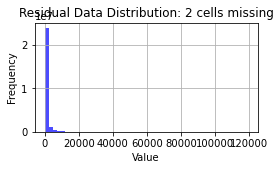

In [27]:
#distribution of residuals
data = residuals[num].values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

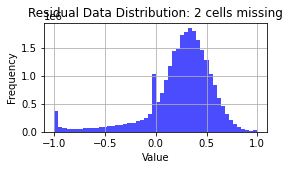

In [28]:
#distribution of residuals
data = residuals_scaled[num].values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Shifting distributions according to above plots, and calculating NMF:

1.0000000000000016


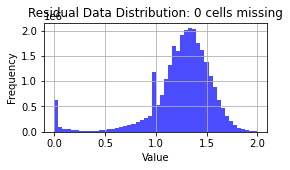

1.0000000000000013


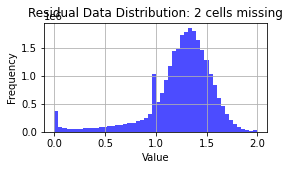

In [29]:
#shift_scaleding distribution of residuals to do NMF
residuals_shift = residuals
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift_scaled distributions minimally:
        min_val = abs(np.min(np.min(residuals_scaled[num])))
        print(min_val)
        residuals_shift[num] = residuals_scaled[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift[num][residuals_shift[num].values <= 0] = 0
    data = residuals_shift[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

1.0000000000000016


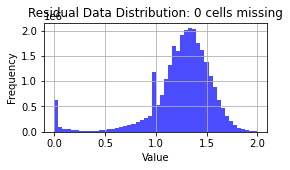

1.0000000000000013


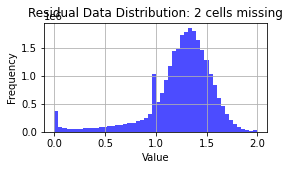

In [30]:
#shift_scaleding distribution of residuals to do NMF
residuals_shift_scaled = residuals_scaled
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift_scaled distributions minimally:
        min_val = abs(np.min(np.min(residuals_scaled[num])))
        print(min_val)
        residuals_shift_scaled[num] = residuals_scaled[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift_scaled[num][residuals_shift_scaled[num].values <= 0] = 0
    data = residuals_shift_scaled[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Now comparing the Residual Scaled (with pseudobulks and reference MinMax scaled) and the Residual (not scaled, all matrices as used in deconvolution). We can see the impact of scaling in our ability to recover the missing cell type's proportions.

Residual, first not scaling the residual or the NMF factors:

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(


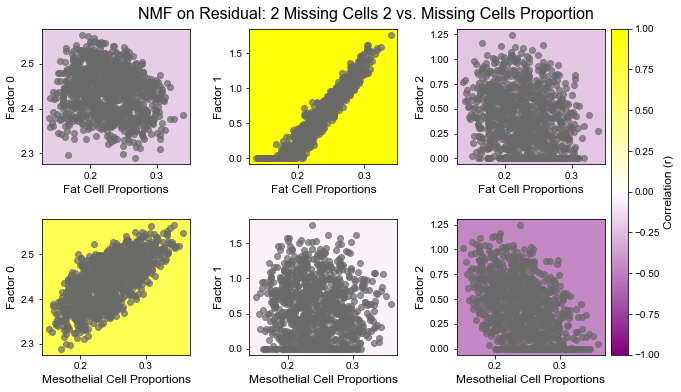

In [31]:
missing_cell_prop[2].columns = ["Fat Cell", "Mesothelial Cell"]
#NMF Residual(by sample) compared to each missing celltype proportion
#nmf on residual 1
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = 3
    nmf = NMF(n_components = num_nmf, max_iter=10, init="nndsvd")
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_heatmaps_real(res_nmf, missing_cell_prop, 2, "NMF", rmse_plot)
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

And now scaled:

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(


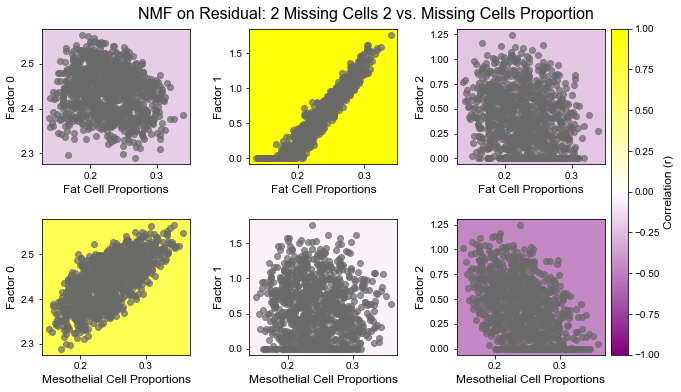

In [32]:
#if proportions are random and RMSE is significant:
if rmse_plot:
    #NMF Residual(by sample) compared to each missing celltype proportion
    res_nmf = dict()
    for num in num_missing_cells:
        num_nmf = num +1
        nmf = NMF(n_components = num_nmf, max_iter = 10 ,init='nndsvd')
        res_nmf_df = nmf.fit_transform(residuals_shift_scaled[num])
        res_nmf_df = pd.DataFrame(res_nmf_df)
        res_nmf[num] = res_nmf_df
        #putting each component between 0 and 1 to match proportion range
        pseudo_raw_val = res_nmf_df.values 
        scaler = MinMaxScaler()
        scaler.fit(pseudo_raw_val)
        pseudo_scale = scaler.transform(pseudo_raw_val)
        res_nmf[num] = pd.DataFrame(pseudo_scale)
#if proportions are not random and RMSE is not significant:
else:
    #NMF Residual(by sample) compared to each missing celltype proportion
    res_nmf = dict()
    for num in num_missing_cells:
        num_nmf = num +1
        nmf = NMF(n_components = num_nmf, max_iter=10, init = 'nndsvd')
        res_nmf_df = nmf.fit_transform(residuals_shift_scaled[num])
        res_nmf_df = pd.DataFrame(res_nmf_df)
        res_nmf[num] = res_nmf_df

vp.factors_vs_proportions_heatmaps_real(res_nmf, missing_cell_prop, 2, "NMF", rmse_plot)
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 